# Introduction

As we described in our previous notebook, we decided to turn this problem into a binary classification problem. We hope to detect differences in weather, climate and city data between fire and non fire events and predict forest fires happening so we can prepare the local population and fire contingencies for the event. 

We are going to first load our data and take one final look at the dataframe to make sure we don't have any unneccessary columns or any information that is missing that we were hoping to have. We will then create dummy variables from our non numerical columns, address data imbalance and split the data set into train, validation and test sets. Then we are going to employ different models and optimize the hyperparameters for each using pipelines and gridsearches. 

In [258]:
#Import necessary packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier  
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import KernelPCA
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample

import time

import warnings
warnings.filterwarnings('ignore')

# 1. Loading the data and cleaning up columns we can't use

Let's load the data we created in our previous notebook and have a quick look at what we have and which columns we need to still remove.

In [259]:
fires = pd.read_csv('data/final_fire_nofire.csv')  

In [260]:
fires.head(2)

,Unnamed: 0,LATITUDE_FIRE,LONGITUDE_FIRE,YEAR,MONTH,DAY,FIRE_DATE,SIZE_HA,CAUSE,FIRE_TYPE,...,DAYS_WITH_VALID_SNOWFALL,COOLING_DEGREE_DAYS,HEATING_DEGREE_DAYS,ELNINO,LANINA,NOENSO,ENSO_STRENGTH,NEAREST_CITY,CITY_DIST,CITY_POP
0,0,54.283,-112.967,2002,11,1.0,2002-11-01,0.0,NaN,NaN,...,0.0,0.0,85.8,0,0,1,NoENSO,Redwater,0.362131,2053
1,1,54.283,-112.967,2002,12,1.0,2002-12-01,0.0,NaN,NaN,...,0.0,0.0,850.1,0,0,1,NoENSO,Redwater,0.362131,2053


In [261]:
fires = fires.drop(columns = 'Unnamed: 0')

In [262]:
fires.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 657937 entries, 0 to 657936
Data columns (total 35 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   LATITUDE_FIRE              657937 non-null  float64
 1   LONGITUDE_FIRE             657937 non-null  float64
 2   YEAR                       657937 non-null  int64  
 3   MONTH                      657937 non-null  int64  
 4   DAY                        657937 non-null  float64
 5   FIRE_DATE                  657937 non-null  object 
 6   SIZE_HA                    657937 non-null  float64
 7   CAUSE                      203819 non-null  object 
 8   FIRE_TYPE                  203979 non-null  object 
 9   STATION_NAME               657937 non-null  object 
 10  FIRE                       657937 non-null  float64
 11  LATITUDE_STATION           657937 non-null  float64
 12  LONGITUDE_STATION          657937 non-null  float64
 13  CLIMATE_ID                 65

For some reason we end up with null values here in Cause and fire type, so we need to fill these again before we start. 

In [263]:
fires['CAUSE'].fillna('None', inplace=True)
fires['FIRE_TYPE'].fillna('None', inplace=True)

We need to make sure we have a dataframe that we can model. For this project the y variable, or the dependent variable is "Fire", which is 0 for no fire and "1" for a fire that happens. X are going to be all our independent variables. Some of the "object" type variables we will remove as they are not relevant and others we are going to "one hot encode" if we want to keep them. So let's have a look at the variables and see. 

Some of the variables are obvious and we don't need to keep them for our modeling. One of them is "NEAREST_CITY". We ahve the distance to the nearest city and the population of the nearest city, we don't need the name of the city. Another one is "STATION_NAME", we have the lat/lon of the station, the name won't be important. So let's delete these columns. 

In [264]:
fires = fires.drop(columns = ['STATION_NAME','NEAREST_CITY'])

What else. We want to keep ENSO_STRENGTH. We will keep "YEAR", "MONTH", "DATE", but we will remove "FIRE_DATE" and "LOCAL_DATE_y" as that is duplicate information. 

In [265]:
fires = fires.drop(columns = ['FIRE_DATE','LOCAL_DATE_y'])

There's really nothing we can do with "CAUSE" as that does not apply to no fire, neither does "FIRE_TYPE". So we can delete these as well.

In [266]:
fires = fires.drop(columns = ['CAUSE','FIRE_TYPE'])

We can also delete "LATITUDE_STATION" and "LONGITUDE_STATION" as the location of the weather station should have no impact on a fire occuring. 

In [267]:
fires = fires.drop(columns = ['LATITUDE_STATION','LONGITUDE_STATION'])

Now we are only left with "ECOZ_NAME", "CLIMATE_ID" and "ENSO_STRENGTH". We want to keep "ECOZ_NAME" in case the ecozone has an impact on there being a fire or not. And we want to keep "ENSO_STRENGTH" as again that might have an impact on there being fires or not. But "CLIMATE_ID" is the number that identifies a weather station so we can delete that. 

In [268]:
fires = fires.drop(columns = ['CLIMATE_ID'])

In [269]:
#Save the final data in case I want to make some plots with it
fires.to_csv("data/final_fire_forplots.csv")  

# 2. Creating dummy variables for our object columns (OHE)

So now we are left with just one column to one hot encode (OHE) for our models, ENSO_STRENGTH. We know we have four ENSO strengths, weak, medium, strong and none. 

In [270]:
fires['ENSO_STRENGTH'].value_counts()

ENSO_STRENGTH
NoENSO    227970
Weak      184396
Strong    117261
Medium    103372
0          24938
Name: count, dtype: int64

We see here that we have some values where the Enso Strength is zero, that would be where we could not match that information in the weather dataframe. So we are going to keep an eye on that after the OHE.

In [271]:
# Get dummy variables for ENSO Strength
fires = pd.concat([fires, pd.get_dummies(fires['ENSO_STRENGTH'], prefix='ENSO').astype(int)], axis=1)

# Drop the original 'Category' column if needed
fires = fires.drop('ENSO_STRENGTH', axis=1)

So this takes care of the object columns, lets double check and make sure we have only numeric columns left now. 

In [272]:
fires.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 657937 entries, 0 to 657936
Data columns (total 30 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   LATITUDE_FIRE              657937 non-null  float64
 1   LONGITUDE_FIRE             657937 non-null  float64
 2   YEAR                       657937 non-null  int64  
 3   MONTH                      657937 non-null  int64  
 4   DAY                        657937 non-null  float64
 5   SIZE_HA                    657937 non-null  float64
 6   FIRE                       657937 non-null  float64
 7   MEAN_TEMPERATURE           657937 non-null  float64
 8   DAYS_WITH_VALID_MEAN_TEMP  657937 non-null  float64
 9   MIN_TEMPERATURE            657937 non-null  float64
 10  DAYS_WITH_VALID_MIN_TEMP   657937 non-null  float64
 11  MAX_TEMPERATURE            657937 non-null  float64
 12  DAYS_WITH_VALID_MAX_TEMP   657937 non-null  float64
 13  TOTAL_PRECIPITATION        65

We need to remove one of the columns for ENSO Strength to avoid multicollinearity. This is also true for one of the columns from ElNino, LaNina and NoEnso. We chose to remove NoEnso and ENSO_NoENSO and we will remove ENSO_0 at the same time as it's also not an ENSO year.

In [273]:
fires = fires.drop('ENSO_NoENSO', axis = 1)

In [274]:
fires = fires.drop('NOENSO', axis = 1)
fires = fires.drop('ENSO_0', axis = 1)

# 3. Multicollinearity

Before we start modeling we need to check which columns are highly correlated with each other so we can make sure to remove them. We can also take a peek at which columns are correlated to the Fire column, giving us a little preview on our possible results.

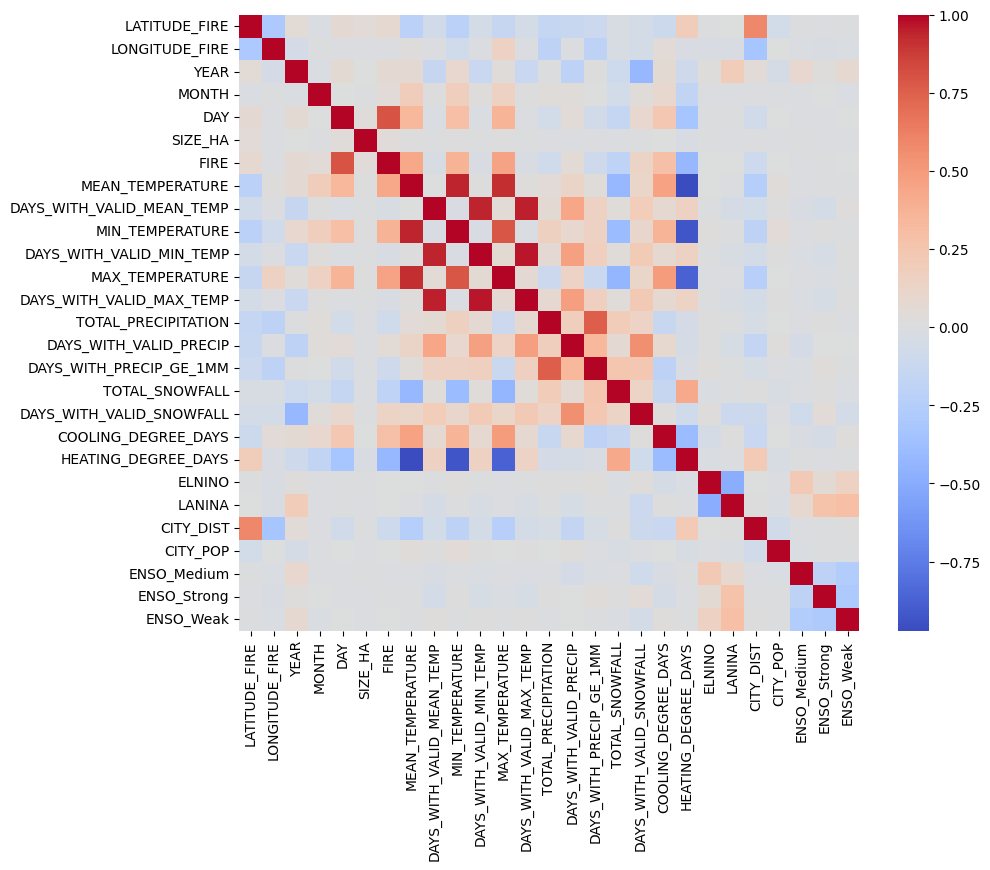

In [275]:
plt.figure(figsize=(10, 8))
sns.heatmap(fires.select_dtypes('number').corr(), cmap='coolwarm')
plt.show()

The first thing to note is that there seems to be a correlation between "FIRE" and "HEATING_DEGREE_DAYS", "COOLING_DEGREE_DAYS", "TOTAL_SNOWFALL", "MAX"/"MIN" AND "MEAN_TEMPERATURE", and the longitude and latitude of the fire. There are some correlations here that we didn't consider before. There is a large correlation here between "Fire" and "Day", which makes perfect sense, as we set all non fire days to 1. So we should probably remove that column unless we have a way to randomize it 

We also forgot that the size of the fire has no impact, so we need to remove that column as well. 

In [276]:
fires = fires.drop('SIZE_HA', axis=1)
fires = fires.drop('DAY', axis=1)

Furthermore we see that all the columns that are "DAYS_WITH_VALID_" are not going to be useful. These are measures of how many days certain measurements were taken in a weather station. We could use this to filter our data on if we wanted to earlier on, but as this point for predicting forest fires, we can drop them as well. 

In [277]:
fires = fires.drop(columns = ['DAYS_WITH_VALID_MEAN_TEMP','DAYS_WITH_VALID_MIN_TEMP','DAYS_WITH_VALID_MAX_TEMP','DAYS_WITH_VALID_PRECIP','DAYS_WITH_VALID_SNOWFALL'])

Another strong correlation we see here is between heating/cooling degree days and the min/max temperatures. This makes sense as the heating degree days are directly calculated from the mean and min/max temperatures. We would also expect the min/max temperatures to be correlated with each other (the higher the max temperature, the higher the min temperature in general in a month) and also with the mean temperature. We need to be careful about which of these we drop.

Maybe to start we can remove the min/max temperature and keep the rest.

In [278]:
fires = fires.drop(columns = ['MIN_TEMPERATURE','MAX_TEMPERATURE'])

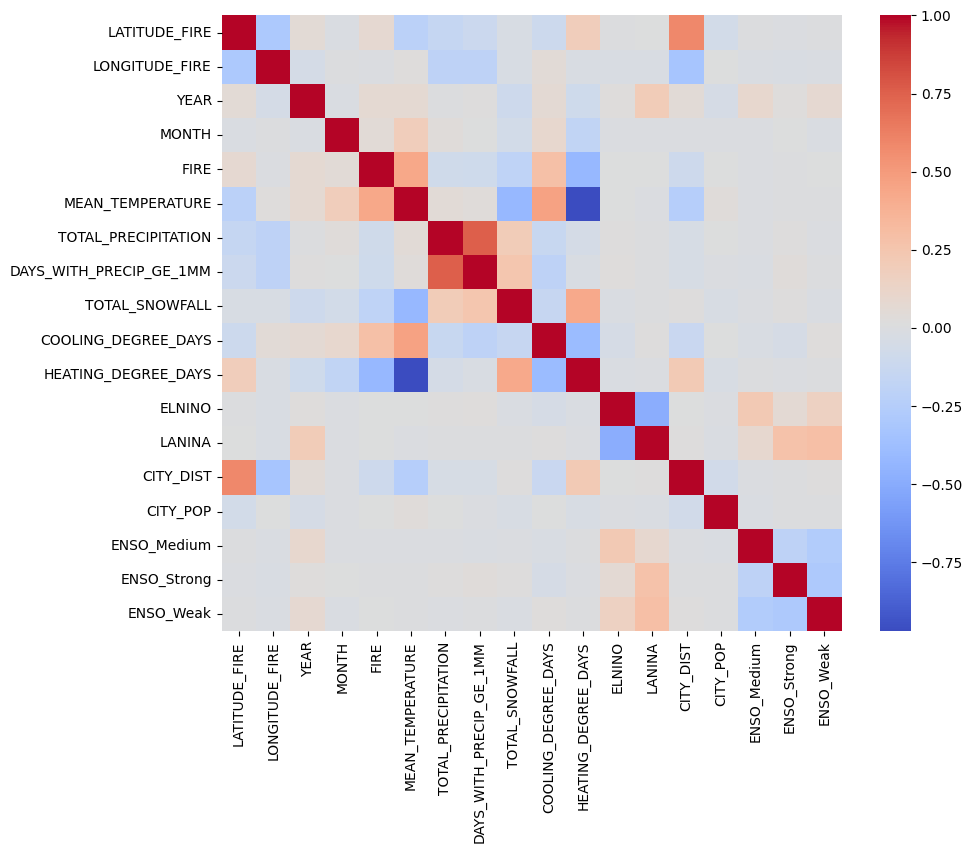

In [279]:
plt.figure(figsize=(10, 8))
sns.heatmap(fires.select_dtypes('number').corr(), cmap='coolwarm')
plt.show()

Then we also have a correlation between "DAYS_WITH_PRECIP_GE_1MM"  and "TOTAL_PRECIPITATION" which of course also makes sense as the more precipitation we have, the more days of rainfall greater than 1mm. So we need to remove "DAYS_WITH_PRECIP_GE_1MM" as well.

In [280]:
fires = fires.drop(columns = ['DAYS_WITH_PRECIP_GE_1MM'])

Finally we do see a correlation between the distance to the nearest city and the Latitude of the fire. This seems to make sense as we go north, there's less and less cities in Western Canada. But let's leave that in for now.

# 4. Addressing class imbalance

We need to talk about class imbalance in this data set of course. We know there is going to be a class imbalance in this data set, simply because there aren't all that many wild fires in Western canada in every month of the year. Especially in fall, winter and spring, where we will have lots and lots of non fire events. But because we have monthly weather data, this imbalance isn't actually as bad in our data as it would be if we used daily weather data from all the weather stations in Western Canada. 

In [281]:
fires['FIRE'].value_counts(normalize = True)*100

FIRE
0.0    68.997184
1.0    31.002816
Name: proportion, dtype: float64

In [289]:
fires['FIRE'].value_counts()

FIRE
0.0    453958
1.0    203979
Name: count, dtype: int64

We see here that in the data set we created we have 68% of all data points that are "No Fire" and 31% of all data points that are "Fire" events. And obviously this isn't true if we looked at daily data, there wildfires would be much much more rare. So going ahead with this data set we need to keep in mind that we are going to be overrepresenting the fire class here. We still think that because we are looking at what climate or other information could give us an indication for a fire event happening and how good our prediction are for that, we are going to go ahead with this anyways. 

If we don't address this imbalance we should note here that if we did nothing, and just guessed if a certain data point was not a wild fire we would be right 69% of the time. So any of our models need to do better than that.

We will go ahead and upsample the fire data so as not to loose more amounts of data. Before we can do that we need to split the data into our train/validation/test sets. Then we upsample the training data as we only want to upsample the data we train our model on. We don't want to upsample the test or validation data as we wouldn't do that if we had real test data coming in.

# 5. Splitting the data into train, validation and test sets

We are going to be splitting our data here into train, validation and test sets. We have decided to split off 20% of the data as a test set and 80% for train and validation. Out of the latter, we are going to split that into 30% test data and 70% training data. 

First step is to turn our dataframe into our independent X and dependent variable y. Then we split those according to the numbers above. 

In [282]:
# Assigning our model variables
X = fires.drop(columns="FIRE")
y = fires["FIRE"]

Now we are ready to split the data:

In [283]:
# First splitting the data into remainder and test sets, 80% remainder and 20% test
X_remainder, X_test, y_remainder, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)

#Splitting the remainder into train and validation sets, 70% train, 30% validation
X_train, X_valid, y_train, y_valid = train_test_split(X_remainder, y_remainder, test_size = 0.3, random_state=1)

Let's make sure that split went well and preserved our fire/no fire ratios:

In [288]:
print('Number of class 1 examples in train set:', X_train[y_train == 1].shape[0])
print('Number of class 0 examples in train set', X_train[y_train == 0].shape[0])
print(f'Fire/No Fire ratio in train set {round((X_train[y_train == 1].shape[0]/X_train[y_train == 0].shape[0])*100,1)} %')
print(f'Fire/No Fire ratio in validation set {round((X_valid[y_valid == 1].shape[0]/X_valid[y_valid == 0].shape[0])*100,1)} %')
print(f'Fire/No Fire ratio in test set {round((X_test[y_test == 1].shape[0]/X_test[y_test == 0].shape[0])*100,1)} %')

Number of class 1 examples in train set: 113940
Number of class 0 examples in train set 254504
Fire/No Fire ratio in train set 44.8 %
Fire/No Fire ratio in validation set 45.3 %
Fire/No Fire ratio in test set 45.0 %


This is exactly what we had before, so we know that did exactly what we wanted it to do. 
Now we can go ahead and upsample our training set.

In [290]:
# Upsample in the train set only as we don't want to change the validation or test sets, we only want to train on an equal set
print('Number of class 1 examples before:', X_train[y_train == 1].shape[0])
print('Number of class 0 examples before:', X_train[y_train == 0].shape[0])

X_upsampled, y_upsampled = resample(X_train[y_train == 1], 
                                    y_train[y_train == 1], 
                                    replace=True, 
                                    n_samples=X_train[y_train == 0].shape[0], 
                                    random_state=123)

print('Number of class 1 examples after:', X_upsampled.shape[0])

# Combine upsample with original data
X_train_bal = np.vstack((X_train[y_train == 0], X_upsampled))
y_train_bal = np.hstack((y_train[y_train == 0], y_upsampled))

# Convert the X variable numpy array into a dataframe
X_train_bal = pd.DataFrame(X_train_bal, columns=X.columns)

Number of class 1 examples before: 113940
Number of class 0 examples before: 254504
Number of class 1 examples after: 254504


We now have a balance training set to model with. We are giong to rename our balanced train sets and let's one more time summarize the shape of the test, validation and training sets. 

In [92]:
y = fires['FIRE']
X = fires.drop(columns=['FIRE'])

In [93]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 657940 entries, 0 to 657939
Series name: FIRE
Non-Null Count   Dtype  
--------------   -----  
657940 non-null  float64
dtypes: float64(1)
memory usage: 5.0 MB


In [94]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 657940 entries, 0 to 657939
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   LATITUDE_FIRE            657940 non-null  float64
 1   LONGITUDE_FIRE           657940 non-null  float64
 2   YEAR                     657940 non-null  int64  
 3   MONTH                    657940 non-null  int64  
 4   MEAN_TEMPERATURE         657940 non-null  float64
 5   TOTAL_PRECIPITATION      657940 non-null  float64
 6   DAYS_WITH_PRECIP_GE_1MM  657940 non-null  float64
 7   TOTAL_SNOWFALL           657940 non-null  float64
 8   COOLING_DEGREE_DAYS      657940 non-null  float64
 9   HEATING_DEGREE_DAYS      657940 non-null  float64
 10  ELNINO                   657940 non-null  int64  
 11  LANINA                   657940 non-null  int64  
 12  CITY_DIST                657940 non-null  float64
 13  CITY_POP                 657940 non-null  int64  
 14  ENSO

We are going to take a 20/80 of our data, 20% for test and 80% for train and validation sets. 

In [95]:
# Splitting remainder and test set
X_remainder, X_test, y_remainder, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)

So now the remainder has 80% of our initial data and we can split that into train and validation sets. We will take 70% of this data for training and 30% for validation. 

In [96]:
# Splitting the remainder in two chunks
X_train, X_validation, y_train, y_validation = train_test_split(X_remainder, y_remainder, test_size = 0.3, random_state=1)

We can check that this is what we have now:

In [97]:
print(f'Shape of test set: {X_test.shape}')
print(f'Shape of validation set: {X_validation.shape}')
print(f'Shape of train set: {X_train.shape}')

Shape of test set: (131588, 17)
Shape of validation set: (157906, 17)
Shape of train set: (368446, 17)


In [292]:
X_train = X_train_bal
y_train = y_train_bal

In [293]:
print(f'Shape of test set: {X_test.shape}')
print(f'Shape of validation set: {X_valid.shape}')
print(f'Shape of train set: {X_train.shape}')

Shape of test set: (131588, 16)
Shape of validation set: (157905, 16)
Shape of train set: (509008, 16)


# 6. Scaling the data

Finally, for some of the models we need to scale the data because the values are all over the place. Because I have a few columns that are 0/1 hot encoded, it would be best to chose to use a minmax scaler. We will probably want to compare different scalers and also no scalers on our models, so we will make sure that we rename our X/y's to "scaled" here so we are able to run the models on unscaled data as well.  

In [294]:
# Create an instance of the MinMaxScaler
my_scaler = MinMaxScaler()

# Fit the scaler to your data and transform the data
scaled_Xtrain = my_scaler.fit_transform(X_train)

Now that we have fit our scaler to the training set, we can then scale the validation and test sets.

In [295]:
scaled_Xvalid = my_scaler.fit_transform(X_valid)
scaled_Xtest = my_scaler.fit_transform(X_test)

In [296]:
X_train.head()

,LATITUDE_FIRE,LONGITUDE_FIRE,YEAR,MONTH,MEAN_TEMPERATURE,TOTAL_PRECIPITATION,TOTAL_SNOWFALL,COOLING_DEGREE_DAYS,HEATING_DEGREE_DAYS,ELNINO,LANINA,CITY_DIST,CITY_POP,ENSO_Medium,ENSO_Strong,ENSO_Weak
0,51.650,-115.283,1976.0,4.0,2.690000,26.5,13.7,0.0,459.3,0.0,1.0,0.553311,7847.0,0.0,1.0,0.0
1,53.567,-112.300,2004.0,10.0,1.916129,20.7,0.0,0.0,498.6,0.0,0.0,0.258671,5708.0,0.0,0.0,0.0
2,49.004,-118.772,2023.0,4.0,7.343333,43.1,0.0,0.0,319.7,0.0,1.0,0.333290,4274.0,0.0,0.0,1.0
3,55.333,-115.417,1985.0,7.0,16.019355,34.1,0.0,10.9,72.3,0.0,1.0,0.622411,1301.0,0.0,0.0,1.0
4,61.333,-129.333,1978.0,4.0,-1.666667,12.0,6.6,0.0,590.0,1.0,0.0,5.770604,25085.0,0.0,0.0,1.0


# 7. Models

We have now done everything we need to jump into the modeling part of this notebook. We want to try different models and see how they perform with our data. We will start with a logistic regression model as it allows easy interpretation of the results and will give us a good baseline to work from. We will then fit a KNN model, a decision tree and finally a random forest model. Each model, we will start out with the default values of the model and then move into hyperparamter optimization. 

## 7.1 Logistic regression

Let's start with a simple logistic regression. In the first step we are going to see what the model can give us without hyperparameter optimization. To do this we will use the scaled data and then we will see what no scaling or StandardScaler use will do to our accuracy when we optimize the parameters. 

One of the requirements for the logistic regression is linearity. We should check all this here, but we will have to come back to it late.r

So to start, as discussed above, let's just run a default logistic regression model and see what accuracies we get. We will use our scaled data for this, which used a MinMax Scaler. 

In [297]:
##### instantiate the models
my_logreg = LogisticRegression()
my_logreg.fit(scaled_Xtrain,y_train)
    
# train the model on traning set
train_score = my_logreg.score(scaled_Xtrain,y_train)
print(f'training accuracy is: {round(train_score*100,2)} %')
# score the model on the validation set
test_score = my_logreg.score(scaled_Xvalid,y_valid)
print(f'validation accuracy is: {round(test_score*100,2)} %')

training accuracy is: 74.3 %
test accuracy is: 71.69 %


This accuracy isn't terrible, but it's also not that great. We can see that there is a 3% difference between test and validation accuracy which is expected.

Before we go into hyperparameter optimization, we first want to see if we can find a better fit using different C values only:

best fit is with a c-value of 0.1 and a validation score of 0.718


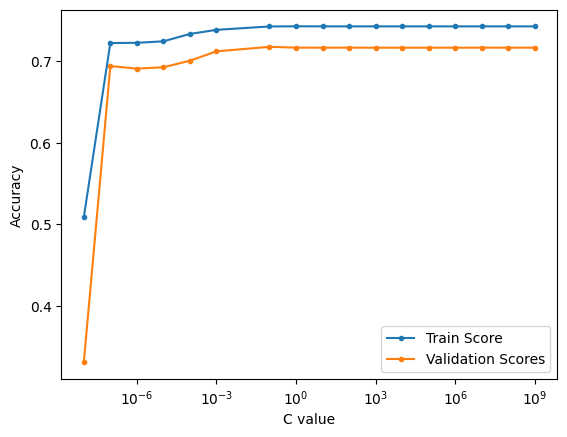

In [299]:
validation_scores = []
train_scores = []

C_range = np.array([.00000001,.0000001,.000001,.00001,.0001,.001,0.1,1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000])

for c in C_range:
    #instantiate the models
    my_logreg = LogisticRegression(C = c,random_state=1)
    my_logreg.fit(scaled_Xtrain,y_train)
    
    # train the model on traning set
    train_scores.append(my_logreg.score(scaled_Xtrain,y_train))
    # score the model on validation set
    validation_scores.append(my_logreg.score(scaled_Xvalid,y_valid))

print(f'best fit is with a c-value of {C_range[np.argmax(validation_scores)]} and a validation score of {round(validation_scores[np.argmax(validation_scores)],3)}')

#Plot the results
plt.figure()
plt.plot(C_range, train_scores,label="Train Score",marker='.')
plt.plot(C_range, validation_scores,label="Validation Scores",marker='.')
plt.xscale('log')
plt.xlabel('C value')
plt.ylabel('Accuracy')
plt.legend()
plt.show();

This tells us that we can get a slightly better score by using a C value of 0.1 instead of the default of 1.

In [306]:
#instantiate the models
my_logreg2 = LogisticRegression(C = 0.1, random_state=1)
my_logreg2.fit(scaled_Xtrain,y_train)
    
# train the model on traning set
train_score = my_logreg2.score(scaled_Xtrain,y_train)
print(f'training accuracy is: {round(train_score*100,2)} %')
# score the model on the validation set
test_score = my_logreg2.score(scaled_Xvalid,y_valid)
print(f'validation accuracy is: {round(test_score*100,2)} %')

training accuracy is: 74.29 %
validation accuracy is: 71.79 %


So training accuracy is is pretty much the same and validation accuracy is a tiny bit improved. 

### 7.1.1 Hyperparameter optimization

Next thing we are going to do is use a pipeline and grid search to see which parameters give us the highest accuracy for our logistic regression model. We will chose different solvers and penalties (L1, L2 and both) and see how much we can push this accuracy.

In [301]:
#we give our estimators as a list of tuples: name:function.
estimators = [('scaler', MinMaxScaler()),
              ('dim_reducer', PCA()),              
              ('model', LogisticRegression())]

my_pipe = Pipeline(estimators)

In [302]:
# Three models, two scalers, two dimensional reducers
# Since each model has different parameter names, they each have to go in a separate dictionary. 


param_grid = [
    {
        'scaler': [MinMaxScaler(), StandardScaler(), None],
        'model': [LogisticRegression()], 
        'model__penalty':['l1','l2','elasticnet'],
        'model__C': [0.001, 0.01, 0.1, 1, 10],
        'model__solver':[None, 'liblinear', 'lbfgs', 'sag', 'saga']
    }
]

grid = GridSearchCV(my_pipe, param_grid, cv=5)

fittedgrid = grid.fit(X_train, y_train)

In [303]:
fittedgrid.best_params_

{'model': LogisticRegression(C=1),
 'model__C': 1,
 'model__penalty': 'l2',
 'model__solver': 'lbfgs',
 'scaler': MinMaxScaler()}

In [304]:
fittedgrid.best_score_

0.7430688692610796

So the accuracy for these parameters is slightly better than what we got for our default model. Let's run our model with those. We can run it on our scaled data as we found the MinMaxScaler to be the best fit anyways!

In [308]:
#instantiate the models
my_logreg_grid = LogisticRegression(C = 1, penalty = 'l2', solver = 'lbfgs',random_state=1)
my_logreg_grid.fit(scaled_Xtrain,y_train)
    
# train the model on traning set
train_score = my_logreg_grid.score(scaled_Xtrain,y_train)
print(f'training accuracy is: {round(train_score*100,2)} %')
# score the model on the validation set
test_score = my_logreg_grid.score(scaled_Xvalid,y_valid)
print(f'validation accuracy is: {round(test_score*100,2)} %')

training accuracy is: 74.3 %
validation accuracy is: 71.69 %


### 7.1.2 Dimension reduction using PCA 

Let's try to run a logistic regression with dimension reducer PCA and see if that would give us any better models. We don't have that many columns in our dataset, so we don't expect the PCA to make a difference. And since it really affects our interpretability of the model, we would much rather not use PCA anyways. Let's see what results we get from this. We are going to add PCA to our grid search above as well as KernelPCA as an option and see what this does to our model results.

In [309]:
estimators = [('scaler', MinMaxScaler()),
              ('dim_reducer', PCA()),              
              ('model', LogisticRegression())]

my_pipe = Pipeline(estimators)

# One model,  two scalers, two dimensional reducers
param_grid = [
    {
        'scaler': [MinMaxScaler(), StandardScaler()],
        'dim_reducer': [PCA(), KernelPCA()],
        'model': [LogisticRegression()], 
        'model__penalty':['l1','l2','elasticnet'],
        'model__C': [0.01,0.1,1,10],
        'model__solver':[None, 'liblinear', 'lbfgs', 'sag', 'saga'],
        'dim_reducer__n_components': [2, 4, 6, 8, 9, 10, 15]
    }
]

grid = GridSearchCV(my_pipe, param_grid, cv=5)

fittedgrid = grid.fit(scaled_Xtrain, y_train)

In [313]:
fittedgrid.best_score_

0.7422535581033392

In [314]:
fittedgrid.best_params_

{'dim_reducer': PCA(n_components=15),
 'dim_reducer__n_components': 15,
 'model': LogisticRegression(C=10, solver='liblinear'),
 'model__C': 10,
 'model__penalty': 'l2',
 'model__solver': 'liblinear',
 'scaler': StandardScaler()}

We see here that using dimensional reduction does not actually make our model better. The accuracy has not increased and the best number of components in a PCA is 15 which is just one less than the 16 we started with. So it's not necessary to use the PCA here. 

### 7.1.3 Interpretation of the results from the logistic regression

Now that we have found the model that gives us the best performance we should look at what this means and how to interpret the results. 
The best model was one that used a C value of 1, a L2 penalty term, and the lbfgs solver. We know want to know for that model, which of the variables played the biggest role in the prediction of our dependent variable. 

Let's first run this model again and see the test accuracy as well and then we will test for feature importance. 

In [316]:
#instantiate the models
my_logreg_grid = LogisticRegression(C = 1, penalty = 'l2', solver = 'lbfgs',random_state=1)
my_logreg_grid.fit(scaled_Xtrain,y_train)
    
# train the model on traning set
train_score = my_logreg_grid.score(scaled_Xtrain,y_train)
print(f'training accuracy is: {round(train_score*100,2)} %')
# score the model on the validation set
valid_score = my_logreg_grid.score(scaled_Xvalid,y_valid)
print(f'validation accuracy is: {round(valid_score*100,2)} %')
# score the model on the test set
test_score = my_logreg_grid.score(scaled_Xtest,y_test)
print(f'test accuracy is: {round(test_score*100,2)} %')

training accuracy is: 74.3 %
validation accuracy is: 71.69 %
test accuracy is: 72.84 %


For our training accuracy in a logistic regression model, 74.3% is the best we can do and with that model we achieve a test accuracy of 72.84%. Now let's look at the importance of the coefficients.

In [310]:
# Get the feature names and coefficients
feature_names = X.columns
coefficients = my_logreg_grid.coef_[0]

# Create a DataFrame to display coefficients with corresponding feature names
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)

# Display the coefficients
print(coefficients_df)

                Feature  Coefficient
4      MEAN_TEMPERATURE    12.447627
6        TOTAL_SNOWFALL     4.931060
0         LATITUDE_FIRE     2.791001
2                  YEAR     0.543415
14          ENSO_Strong     0.109216
9                ELNINO     0.101836
15            ENSO_Weak     0.077899
10               LANINA     0.019824
13          ENSO_Medium    -0.026422
12             CITY_POP    -0.082080
1        LONGITUDE_FIRE    -0.387354
3                 MONTH    -0.865382
7   COOLING_DEGREE_DAYS    -1.283345
8   HEATING_DEGREE_DAYS    -2.124230
11            CITY_DIST    -3.751466
5   TOTAL_PRECIPITATION    -5.223056


Let's plot these as it will be easier to look at them that way:

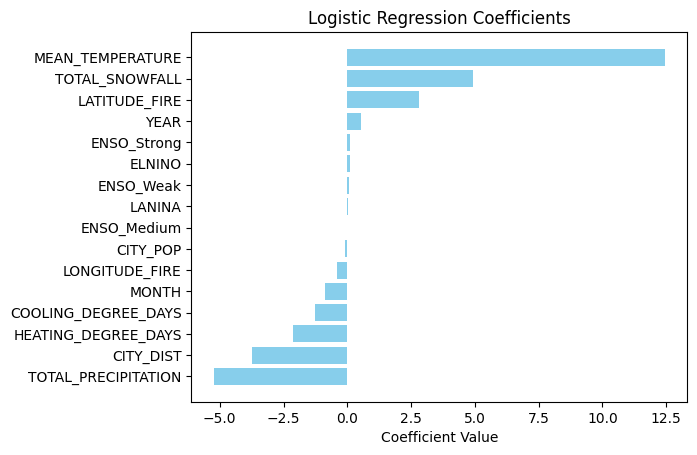

In [311]:
plt.figure()#figsize=(10, 6))
plt.barh(coefficients_df['Feature'], coefficients_df['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Logistic Regression Coefficients')
plt.gca().invert_yaxis()  # Invert the y-axis to display the most important features at the top
plt.show()

We see from these coefficients that in this logistic regression model, the mean temperature plays the largest role in predicting a fire. This makes sense intuitively, the higher the monthly mean temperature, the more likely we would have a fire. The same can not be said for total snowfall. We would not expect to see an increase in fire likelihood when we increase the total snowfall. In terms of negative coefficients, the total monthly precipitation has a negative correlation to "fire". So the larger the total monthly precipitation the more likely we are to have no fire, that makes sense again. The second largest coefficient comes from distance to the closest city. And again, that makes sense, when that distance increases we are more likely to see no fire. 

## 7.2 KNN model

Next we are going to fit a KNN model and see if it can perform any better than our logistic regression model. To do this, we will start with the default k and see what the results look like before trying to optimize the k in the next step. We should note here that the KNN model will take a while to run as it is computationally expensive. We use our MinMaxScaler scaled data here as this model depends on distances and these need to be scaled to make sense. 

In [312]:
#Instantiate the model
my_KNN = KNeighborsClassifier()

#Fit the model
my_KNN.fit(scaled_Xtrain, y_train)

train_predictions = my_KNN.predict(scaled_Xtrain)
train_accuracy = accuracy_score(train_predictions, y_train)
print(f'Model accuracy for Train set: {round(train_accuracy,4)*100} %')

valid_predictions = my_KNN.predict(scaled_Xvalid)
valid_accuracy = accuracy_score(valid_predictions, y_valid)
print(f'Model accuracy for validation set: {round(valid_accuracy,4)*100} %')

test_predictions = my_KNN.predict(scaled_Xtest)
test_accuracy = accuracy_score(test_predictions, y_test)
print(f'Model accuracy for Test set: {round(test_accuracy,4)*100} %')

Model accuracy for Train set: 97.72 %
Model accuracy for validation set: 95.14 %
Model accuracy for Test set: 95.15 %


We see here that this is a huge improvement over the logistic regression model. This is something we expected as the data has more complexities to the relation between the variables and we expected KNN or later on a Decision Tree/random forest model to pick up these slight differences and complex connections better. 

We can once again see if we can find a better k here:

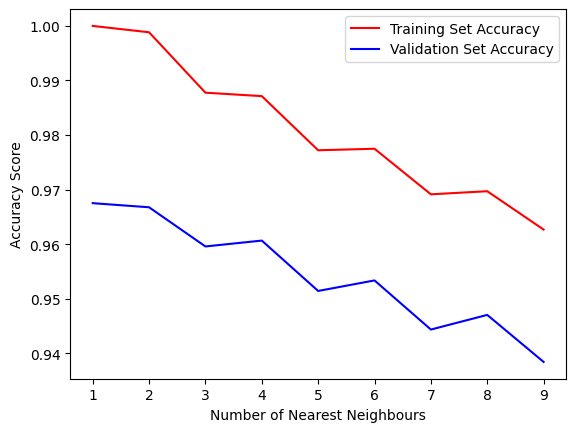

In [332]:
#Finding a better k:
k_range = list(range(1,251,50))
number_neighbors = []
train_acc = []
valid_acc = []

#try different numbers of neighbors and calculate accuracies
for k in k_range:
    my_KNN = KNeighborsClassifier(n_neighbors = k)
    my_KNN.fit(scaled_Xtrain, y_train)
    
    #Score the model
    train_predictions = my_KNN.predict(scaled_Xtrain)
    train_accuracy = accuracy_score(train_predictions, y_train)
    valid_predictions = my_KNN.predict(scaled_Xvalid)
    valid_accuracy = accuracy_score(valid_predictions, y_valid)
    train_acc.append(train_accuracy)
    valid_acc.append(valid_accuracy)
    number_neighbors.append(k)
    #print(k)

plt.figure()
plt.plot(number_neighbors, train_acc, label="Training Set Accuracy",color='red')
plt.plot(number_neighbors, valid_acc, label="Validation Set Accuracy",color='blue')
plt.legend()
plt.xlabel('Number of Nearest Neighbours')
plt.ylabel('Accuracy Score')
plt.show()

From this plot we could conclude that we use a number of nearest neighbors closer to 150. Let's see what our accuracies are if we use k=150:

In [319]:
#Instantiate the model
my_KNN2 = KNeighborsClassifier(n_neighbors = 150)

#Fit the model
my_KNN2.fit(scaled_Xtrain, y_train)

train_predictions = my_KNN2.predict(scaled_Xtrain)
train_accuracy = accuracy_score(train_predictions, y_train)
print(f'Model accuracy for Train set: {round(train_accuracy,4)*100} %')

valid_predictions = my_KNN2.predict(scaled_Xvalid)
valid_accuracy = accuracy_score(valid_predictions, y_valid)
print(f'Model accuracy for validation set: {round(test_accuracy,4)*100} %')


Model accuracy for Train set: 86.91 %
Model accuracy for validation set: 84.54 %


This is a big imporvement over the logistic regression model, but maybe we can do better. We will run a grid search and see if we should chose some other parameters here to make this an even better fitting model. 

### 7.2.1 Grid search for KNN model
Just like before it's time to do a grid search for this KNN model to see how to optimize the hyper parameters for this model. 

In [322]:
#we give our estimators as a list of tuples: name:function.
estimators = [('scaler', MinMaxScaler()),
               ('model', KNeighborsClassifier())]

my_pipe = Pipeline(estimators)

In [324]:
# Grid search for the KNN model
param_grid = [
    {
        'scaler': [MinMaxScaler(), StandardScaler()],
        'model': [KNeighborsClassifier()], 
        'model__n_neighbors':[5,20,150],
        'model__weights': ['uniform','distance'],
        'model__p':[1,2]
    }
]

gridknn = GridSearchCV(my_pipe, param_grid, cv=2)

fittedgridknn = grid.fit(scaled_Xtrain, y_train)

In [330]:
fittedgridknn.best_score_

0.9686429289912928

In [331]:
fittedgridknn.best_params_

{'model': KNeighborsClassifier(p=1, weights='distance'),
 'model__n_neighbors': 5,
 'model__p': 1,
 'model__weights': 'distance',
 'scaler': StandardScaler()}

Looking at these parameters we know that the k value of 5 is giving a better result in terms of accuracy but we also know that that is not the best choice here. It's interesting to see that p=1 and distance are the best parameters here because in the default case above we would be using p = 2 and weights = 'uniform'. We can now rerun the KNN model with these parameters to see which variables are most important in this model. 

In [337]:
#Instantiate the model
my_KNNf = KNeighborsClassifier(n_neighbors = 5, p = 1, weights = 'distance')

#Fit the model
my_KNNf.fit(scaled_Xtrain, y_train)

train_predictions = my_KNNf.predict(scaled_Xtrain)
train_accuracy = accuracy_score(train_predictions, y_train)
print(f'Model accuracy for Train set: {round(train_accuracy,4)*100} %')

valid_predictions = my_KNNf.predict(scaled_Xvalid)
valid_accuracy = accuracy_score(valid_predictions, y_valid)
print(f'Model accuracy for validation set: {round(valid_accuracy,4)*100} %')

test_predictions = my_KNNf.predict(scaled_Xtest)
test_accuracy = accuracy_score(test_predictions, y_test)
print(f'Model accuracy for validation set: {round(test_accuracy,4)*100} %')

Model accuracy for Train set: 100.0 %
Model accuracy for validation set: 96.37 %
Model accuracy for validation set: 96.21 %


That did increase our accuracy by a lot, but we think we should've used k = 150. Our test accuracy is now 96% which would be great to have. 

### 7.2.2 Interpretation of KNN model results

To interpret the results of our KNN model lets recap to start. With the hyper parameters of n_neighbors = 5, p = 1 (Manhattan distances) and weights = 'distance' (closer neighbours have more influence), we find a test accuracy of %.

Just like before, let's have a look at which variables have the biggest influence on the model:

In [ ]:
from sklearn.inspection import permutation_importance

# Calculate permutation importances
perm_importances = permutation_importance(my_KNNf, X_test, y_test, n_repeats=30, random_state=0)

# Access the importances for each feature
feature_importances = perm_importances.importances_mean

In [ ]:
# Get the names of your features (assuming X is a pandas DataFrame)
feature_names = X.columns

# Sort the features by importance (descending order)
sorted_idx = feature_importances.argsort()[::-1]

# Plot the permutation importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.xticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Permutation Importance')
plt.title('Permutation Importance for KNN Features')
plt.tight_layout()
plt.show()

## 7.3  Decision Tree

The next model we want to look at is a decision tree model. We will start with that and then branch out into a random forest model. As before, let's start with the default model for this. Since we are not using any kind of distances in this model we do not need to use the scaled data, but we can use the unscaled data. 

In [341]:
# Instantiate & fit the DT
DT_model = DecisionTreeClassifier()
DT_model.fit(X_train, y_train)

# Evaluate its classification accuracy (Just on the training and validation set for now)
print(f"DT training set accuracy: {DT_model.score(X_train, y_train)}")
print(f"The validation classification accuracy is:  {DT_model.score(X_valid,y_valid)}")

DT training set accuracy: 1.0
The validation classification accuracy is:  0.988778062759254


So right away we see that the validation accuracy is really good at 98.9%.

We can now perform a search to see how  much the accuracy changes as we change the depth of our tree:

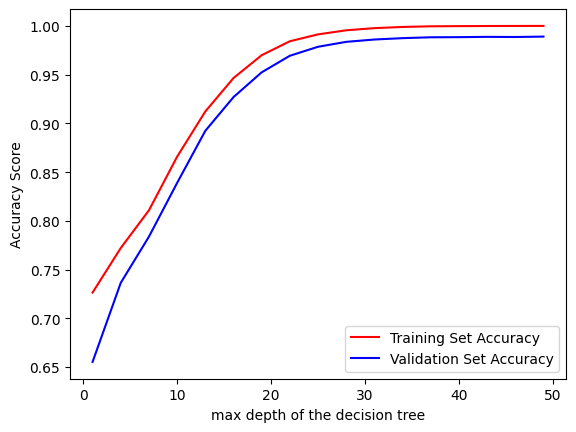

In [345]:
#Finding a better depth max_depth
depth_range = list(range(1,52,3))
number_depth = []
train_acc = []
valid_acc = []

#try different numbers of neighbors and calculate accuracies
for d in depth_range:
    my_DT2 = DecisionTreeClassifier(max_depth = d)
    my_DT2.fit(X_train, y_train)
    
    #Score the model
    train_predictions = my_DT2.predict(X_train)
    train_accuracy = accuracy_score(train_predictions, y_train)
    valid_predictions = my_DT2.predict(X_valid)
    valid_accuracy = accuracy_score(valid_predictions, y_valid)
    train_acc.append(train_accuracy)
    valid_acc.append(valid_accuracy)
    number_depth.append(d)
    #print(d)

plt.figure()
plt.plot(number_depth, train_acc, label="Training Set Accuracy",color='red')
plt.plot(number_depth, valid_acc, label="Validation Set Accuracy",color='blue')
plt.legend()
plt.xlabel('max depth of the decision tree')
plt.ylabel('Accuracy Score')
plt.show()

From this plot we can identify that the best maximum depth to use is probably 25. Let's rerun the model with this and see what that looks like.

In [346]:
# Instantiate & fit the DT
DT_model = DecisionTreeClassifier(max_depth = 25)
DT_model.fit(X_train, y_train)

# Evaluate its classification accuracy (Just on the training and validation set for now)
print(f"DT training set accuracy: {DT_model.score(X_train, y_train)}")
print(f"The validation classification accuracy is:  {DT_model.score(X_valid,y_valid)}")

DT training set accuracy: 0.9913184075692327
The validation classification accuracy is:  0.9783604065735727


This is great to see, we now no longer have a training accuracy of 1, but of 99% and the validation accuracy is 97.8%. We are not going to run a grid search on the decision tree model but leave that for the random forest model. Let's run this model and see the accuracy for the test data.

In [348]:
print(f"The validation classification accuracy is:  {DT_model.score(X_test,y_test)}")

The validation classification accuracy is:  0.977991914156306


With a test accuracy of 97.8%, that is a great value. 
 

### 7.3.1. Decision Tree model interpretation

Since this model looks great we want to know what the confusion matrix would look like in this case. This will give us information on how well we are predicting fires and non fires as it also tells us the false positives and negatives we would observe. We calculate this confusion matrix using the test data set.

,Predicted Negative,Predicted Positive
True Negative,88449,2305
True Positive,591,40243


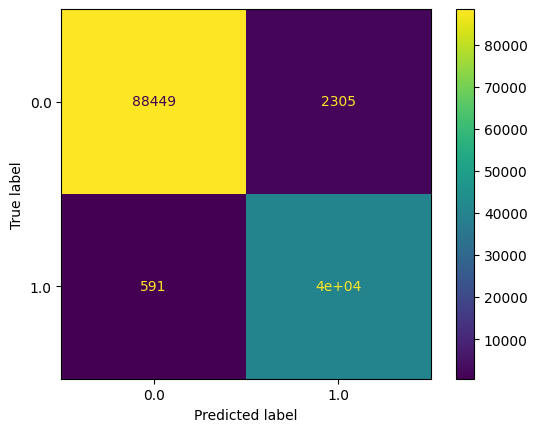

In [349]:
# Get class predictions from the scaled test data
y_pred = DT_model.predict(X_test)

# create the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# Turn the matrix into a dataframe
cf_df = pd.DataFrame( cf_matrix, 
    columns=["Predicted Negative", "Predicted Positive"],
    index=["True Negative", "True Positive"]
)

display(cf_df)

# display as a heat map
ConfusionMatrixDisplay.from_estimator(DT_model, X_test, y_test);

We see in the confustion matrix that there are quite a lot of false positives (2305 or 1.8% of the data) and slightly less false negatives at 591 or 0.4% of the data. 
We would probably be concerened about too many false positives since telling people there will be a fire and evacuating them and then nothing happens is not going to be popular. But the really dangerous part of this are the false negatives. So we should want to keep this number as small as possible. 

Finally let's check the feature importance in this decision tree model:

In [362]:
# Access feature importances
feature_importances = DT_model.feature_importances_
feature_names = X.columns

coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': feature_importances})
coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)

# Display the coefficients
print(coefficients_df)

                Feature  Coefficient
4      MEAN_TEMPERATURE     0.327608
0         LATITUDE_FIRE     0.136928
1        LONGITUDE_FIRE     0.106785
11            CITY_DIST     0.106679
12             CITY_POP     0.086900
2                  YEAR     0.068742
5   TOTAL_PRECIPITATION     0.056649
8   HEATING_DEGREE_DAYS     0.038470
3                 MONTH     0.034611
7   COOLING_DEGREE_DAYS     0.015808
6        TOTAL_SNOWFALL     0.010379
9                ELNINO     0.002416
14          ENSO_Strong     0.002288
10               LANINA     0.002082
15            ENSO_Weak     0.002022
13          ENSO_Medium     0.001634


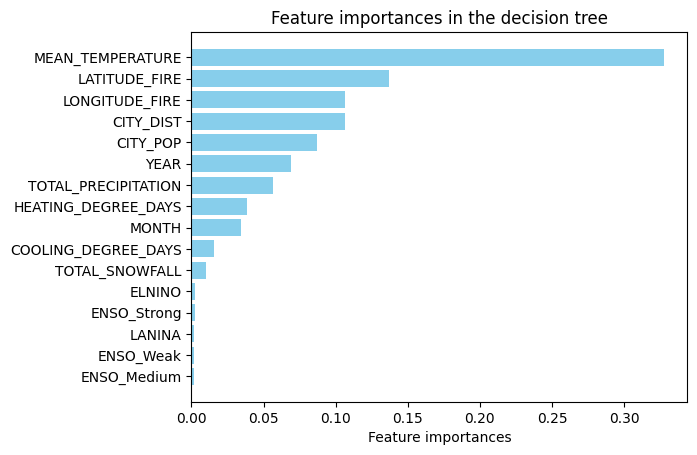

In [363]:
plt.figure()#figsize=(10, 6))
plt.barh(coefficients_df['Feature'], coefficients_df['Coefficient'], color='skyblue')
plt.xlabel('Feature importances')
plt.title('Feature importances in the decision tree')
plt.gca().invert_yaxis()  # Invert the y-axis to display the most important features at the top
plt.show()

For this model we see again that the Mean temperature of the month the fire occurs in is an important feature as well as the location of the fire and the distance to the nearest city one more time. Here again we see that the ENSO information plays the smallest role in predicting forest fires. 

Let's now move on to a random forest model.

## 7.4 Random Forest

Since the decision tree gave us such good accuracy we think it is definitely worth trying a random forest model as well

Random Forest model:

In [364]:
# Create a Random Forest Classifier instance
rf_model = RandomForestClassifier(random_state=42)

# Train the model on the training data
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [365]:
params = rf_model.get_params()
print(params)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [366]:
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')

Accuracy: 0.998388910842934
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     90754
         1.0       1.00      0.99      1.00     40834

    accuracy                           1.00    131588
   macro avg       1.00      1.00      1.00    131588
weighted avg       1.00      1.00      1.00    131588



We would like to know what depth this random forest model went to with the trees, so we are going to access the individual tress and take an average of the tree depth.

In [367]:
# Access the individual decision trees
individual_trees = rf_model.estimators_
numberTrees = 0
depth_total = 0

# Loop through the trees and get their depths
for i, tree in enumerate(individual_trees):
    depth = tree.get_depth()
    #print(f"Tree {i + 1}: Depth = {depth}")
    depth_total +=depth
    numberTrees +=1
    
average= depth_total/numberTrees
print(average)

43.71


So the average depth of the 100 decision trees in this random forest model was 44. This will be good to know, so that when we run our random forest hyperparameter optimizing grid search, we have something to compare the results to. 

We can now also take this random forest model and see how this did with respect to false positives and negatives.

,Predicted Negative,Predicted Positive
True Negative,90748,6
True Positive,206,40628


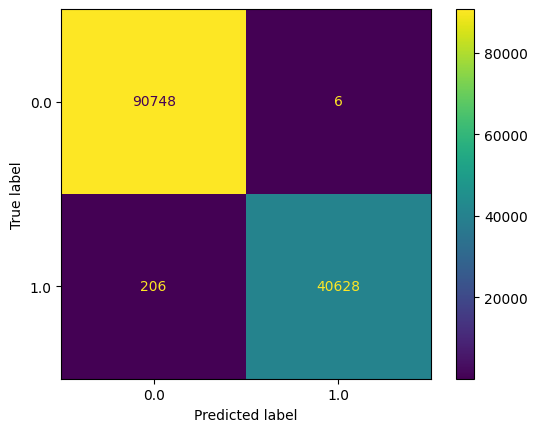

In [369]:
# Get class predictions from the scaled test data
y_pred = rf_model.predict(X_test)

# create the confustion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# Turn the matrix into a dataframe
cf_df = pd.DataFrame( cf_matrix, 
    columns=["Predicted Negative", "Predicted Positive"],
    index=["True Negative", "True Positive"]
)

display(cf_df)

# display as a heat map
ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test);

We see here right away that the random forest model does better than a single decision tree with false positves (7 or 0.01% of the data) and false negatives (211 events or 0.2% of the data). 

Let's now move on and do a grid search for the random forests. 

## 7.4.1 Grid Search for the random forest

Let's do a hyperparameter grid search for the random forest data:

In [190]:
# Create placeholders for all three steps
estimators = [
    ('model', RandomForestClassifier(random_state=42))
]

my_pipe = Pipeline(estimators)

In [191]:
rf_modelf = RandomForestClassifier(random_state=42)

# Define a grid of hyperparameters to search
param_grid = {
    'model__n_estimators': [20, 100, 150],          # Number of trees in the forest
    'model__max_depth': [10, 50, 100],         # Maximum depth of the trees
    'model__min_samples_leaf': [10, 50],          # Minimum number of samples required to be a leaf node
}

# Create a GridSearchCV instance
grid_search = GridSearchCV(my_pipe, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and best estimator from the grid search
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

# Print the best parameters and best estimator
print("Best Parameters:", best_params)
print("Best Estimator:", best_estimator)

# Evaluate the best model on the validation data
y_pred = best_estimator.predict(X_valid)
accuracy = accuracy_score(y_valid, y_pred)
print("Validation Accuracy:", accuracy)

Best Parameters: {'model__max_depth': 50, 'model__min_samples_leaf': 10, 'model__n_estimators': 150}
Best Estimator: Pipeline(steps=[('scaler', StandardScaler()), ('dim_reducer', PCA()),
                ('model',
                 RandomForestClassifier(max_depth=50, min_samples_leaf=10,
                                        n_estimators=150, random_state=42))])
Test Accuracy: 0.9791014907603257


Have a look at feature importance in the random forest model using the hyperparameters found in the grid search above. 

In [370]:
# Create a Random Forest Classifier instance
rf_modelf = RandomForestClassifier(max_depth = 50, min_samples_leaf = 10, n_estimators = 150, random_state=42)

# Train the model on the training data
rf_modelf.fit(X_train, y_train)

RandomForestClassifier(max_depth=50, min_samples_leaf=10, n_estimators=150,
                       random_state=42)

Let's see the test accuracy of this hyperparameter optimized model:

In [371]:
y_pred = rf_modelf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')

Accuracy: 0.9952123293917379
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     90754
         1.0       1.00      0.99      0.99     40834

    accuracy                           1.00    131588
   macro avg       1.00      0.99      0.99    131588
weighted avg       1.00      1.00      1.00    131588



In [372]:
#Access feature importances
feature_importances = rf_modelf.feature_importances_

# Get the names of the features
feature_names = X_train.columns  # Replace with the actual names of your features

# Create a dictionary to pair feature names with their importances
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort features by importance (descending order)
sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the feature importances
for feature, importance in sorted_feature_importances:
    print(f"{feature}: {importance}")

MEAN_TEMPERATURE: 0.15976464138233387
HEATING_DEGREE_DAYS: 0.14538270110218113
LATITUDE_FIRE: 0.10544211466228962
LONGITUDE_FIRE: 0.09094636510838199
CITY_DIST: 0.08928381328751639
COOLING_DEGREE_DAYS: 0.0815193273153653
CITY_POP: 0.07458604727942847
YEAR: 0.07311134510585013
TOTAL_PRECIPITATION: 0.06304018037357546
MONTH: 0.05932004647689401
TOTAL_SNOWFALL: 0.031204620412081666
ENSO_Weak: 0.006237694206207211
ELNINO: 0.00583922198424869
LANINA: 0.005315457715850752
ENSO_Strong: 0.005177371499189184
ENSO_Medium: 0.0038290520886061596


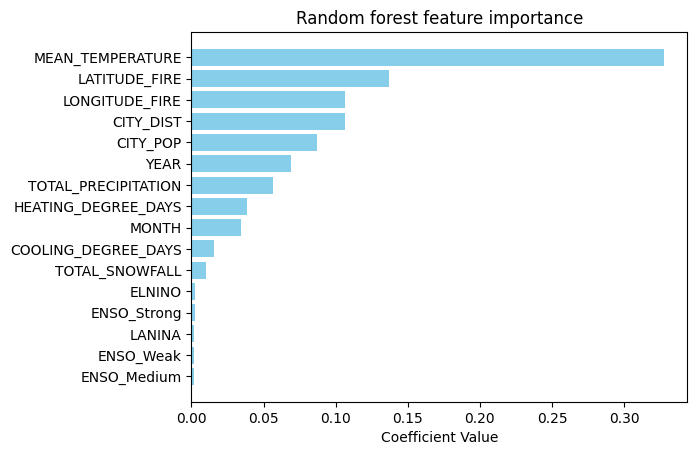

In [373]:
plt.figure()#figsize=(10, 6))
plt.barh(coefficients_df['Feature'], coefficients_df['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Random forest feature importance')
plt.gca().invert_yaxis()  # Invert the y-axis to display the most important features at the top
plt.show()

And we can also take a look at the confusion matrix for this model:

,Predicted Negative,Predicted Positive
True Negative,90642,112
True Positive,518,40316


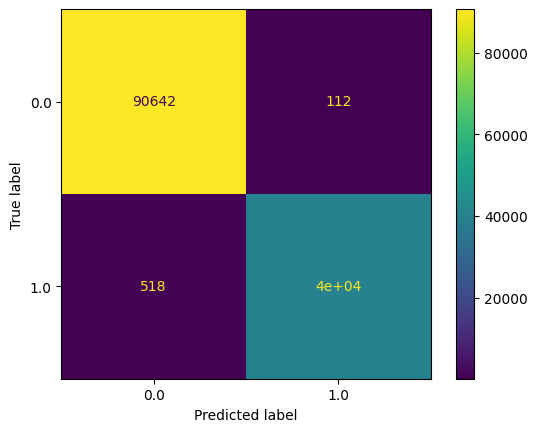

In [375]:
# Get class predictions from the scaled test data
y_pred = rf_modelf.predict(X_test)

# create the confustion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# Turn the matrix into a dataframe
cf_df = pd.DataFrame( cf_matrix, 
    columns=["Predicted Negative", "Predicted Positive"],
    index=["True Negative", "True Positive"]
)

display(cf_df)

# display as a heat map
ConfusionMatrixDisplay.from_estimator(rf_modelf, X_test, y_test);

For this random forest model these false positives (112 or 0.09% of the data) and negatives (518 or 0.4%) are very similar to the earlier ones. These are very small and if have a few thousand fires a year that would mean a few false positives and a dozen or so false negatives. This number might be small enough to deal with.

# 8. Conclusion

We have shown in this section of our notebook that we can fit various different models to our forest fire dataframe which gave us teset accuracies ranging from 73% for logistic regression to 98% for a random forest model. We saw that the most important features of our data are the mean temperature and distance to the closest city as well as precipitation. 

We would like to fit a few more models to this data, which we will hope to do in teh future and adjust the data to include more weather information from previous months or years for all the fire data and potentially daily weather data as well. 